### Loading used packages

In [1]:
import os
import numpy as np
import geopandas as gpd
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib import pyplot as plt

### Download nightlight intensity data in given region

In [37]:
# The nightlight images was download from dataset: NOAA/VIIRS/DNB/ANNUAL_V22 using the google earth engine scripts.
# The image was also converted into GTiff and clip by given region

In [39]:
# A shapefile with grids (500m * 500m) was built in Qgis in given region first,
# Zonal statistics was applied on image and grids shapefile to get nightlight intensity for each grid.
# producing a new shapefile called 'nightlight_grids.shp'

In [10]:
# using geopands read nightlight_grids.shp file
nightlight_grids = gpd.read_file(r'nightlight_grids.shp')

In [41]:
# check its length and columns, intensity is the value from nightlight images.
print(nightlight_grids.head())

    id      left        top     right     bottom  intensity  \
0  1.0  643500.0  5750000.0  644000.0  5749500.0   1.730895   
1  2.0  643500.0  5749500.0  644000.0  5749000.0   2.094511   
2  3.0  643500.0  5749000.0  644000.0  5748500.0   1.997370   
3  4.0  643500.0  5748500.0  644000.0  5748000.0   1.873754   
4  5.0  643500.0  5748000.0  644000.0  5747500.0   1.907341   

                                            geometry  
0  POLYGON ((643500.000 5750000.000, 644000.000 5...  
1  POLYGON ((643500.000 5749500.000, 644000.000 5...  
2  POLYGON ((643500.000 5749000.000, 644000.000 5...  
3  POLYGON ((643500.000 5748500.000, 644000.000 5...  
4  POLYGON ((643500.000 5748000.000, 644000.000 5...  


### Download street network data from openstreetmap dataset

In [42]:
# duo to the size of given region, which is larger than 0.5 degree * 0.5 degree, here only great london region was download fro analysis.
# here is the download link:https://download.geofabrik.de/europe/united-kingdom/england/greater-london.html 

In [45]:
# Using intersction analysis to get intersection between grids and street network data, which is nightlight_street_network.shp file here.
# due to its large size, it is not uploaded to github repo.

In [36]:
# load the intersection data using geopandas
nightlight_street_network = gpd.read_file(r'nightlight_street_network.shp')

In [46]:
# check out dataframe
print(nightlight_street_network.head())

  osm_id              name  highway waterway aerialway barrier man_made  \
0     74     Ballards Lane  primary      NaN       NaN     NaN      NaN   
1     75         High Road  primary      NaN       NaN     NaN      NaN   
2     79     East End Road  primary      NaN       NaN     NaN      NaN   
3     79     East End Road  primary      NaN       NaN     NaN      NaN   
4    482  Cockfosters Road  primary      NaN       NaN     NaN      NaN   

   z_order                                         other_tags       id  \
0        7  "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A598...  17432.0   
1        7  "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A100...  17772.0   
2        7    "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A504"  17433.0   
3        7    "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A504"  17605.0   
4        7    "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A111"  18104.0   

   intensity                                           geometry  
0  29.737795  LINESTRING (694381.194 5

In [48]:
# add length field in geo dataframe
nightlight_street_network['road_len'] = nightlight_street_network['geometry'].length

In [49]:
# check out dataframe again
print(nightlight_street_network.head())

  osm_id              name  highway waterway aerialway barrier man_made  \
0     74     Ballards Lane  primary      NaN       NaN     NaN      NaN   
1     75         High Road  primary      NaN       NaN     NaN      NaN   
2     79     East End Road  primary      NaN       NaN     NaN      NaN   
3     79     East End Road  primary      NaN       NaN     NaN      NaN   
4    482  Cockfosters Road  primary      NaN       NaN     NaN      NaN   

   z_order                                         other_tags       id  \
0        7  "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A598...  17432.0   
1        7  "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A100...  17772.0   
2        7    "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A504"  17433.0   
3        7    "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A504"  17605.0   
4        7    "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A111"  18104.0   

   intensity                                           geometry    road_len  
0  29.737795  LINESTRING (

In [62]:
# group data with grid id to get total road length for each grid.
grouped_stats = nightlight_street_network.groupby(['id']).agg(
    total_length=('road_len', 'sum'),
    Intensity=('intensity', 'mean')
).reset_index()

In [63]:
print(grouped_stats)

           id  total_length  Intensity
0      7648.0    418.301213  59.762184
1      7820.0    538.174275  23.684908
2      7992.0    532.373584  32.140236
3      8164.0    592.505583  39.135761
4      8336.0     75.619276  24.746420
...       ...           ...        ...
8016  31733.0    517.342648   9.024424
8017  31734.0    517.072472  10.297158
8018  31735.0    259.024275  12.324800
8019  31903.0    187.309389   8.341946
8020  31904.0    182.741387   8.341946

[8021 rows x 3 columns]


In [65]:
# extracting nightlight and road length per grid from dataframe
nightlight_value_per_grids = grouped_stats['Intensity']
road_length_per_grids = grouped_stats['total_length']

In [66]:
# calculate correlation
corr_coef, p_value = pearsonr(road_length_per_grids, nightlight_value_per_grids)
print(f"Pearson correlation coefficient: {corr_coef:.2f}")

Pearson correlation coefficient: 0.53


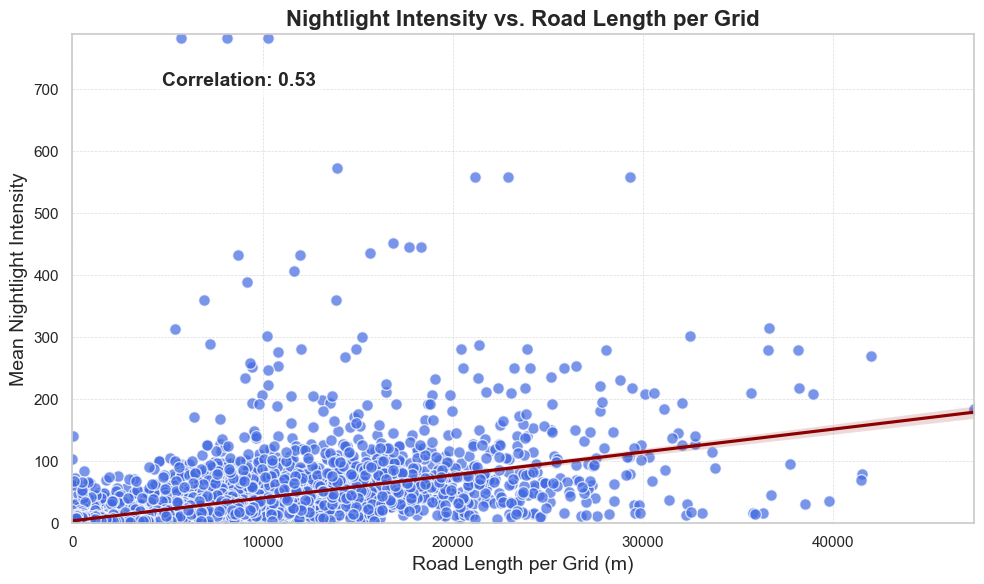

In [67]:
# plot them with seaborn and put regression line and correaltion coefficience on the figure
sns.set(style="whitegrid")

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = sns.regplot(x=road_length_per_grids, y=nightlight_value_per_grids, 
                      color="royalblue", line_kws={"color": "darkred"}, 
                      scatter_kws={"s": 70, "edgecolor": "w", "alpha": 0.7})

plt.text(0.1 * road_length_per_grids.max(), 
         0.9 * nightlight_value_per_grids.max(), 
         f"Correlation: {corr_coef:.2f}", 
         fontsize=14, 
         weight='bold', 
         bbox=dict(facecolor='white', alpha=0.5, boxstyle='round,pad=0.3'))

# Titles and labels
plt.title("Nightlight Intensity vs. Road Length per Grid", fontsize=16, weight='bold')
plt.xlabel("Road Length per Grid (m)", fontsize=14)
plt.ylabel("Mean Nightlight Intensity", fontsize=14)

# Add gridlines and limit scales if desired
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.xlim(0, road_length_per_grids.max() + 5)   # Add buffer for better visualization
plt.ylim(0, nightlight_value_per_grids.max() + 5)

# Show the plot
plt.tight_layout()
plt.show()

In [83]:
nightlight_street_network['highway'].unique

<bound method Series.unique of 0         primary
1         primary
2         primary
3         primary
4         primary
           ...   
833649    footway
833650    footway
833651    footway
833652    footway
833653        NaN
Name: highway, Length: 833654, dtype: object>

In [84]:
highway_nightlight = nightlight_street_network[nightlight_street_network['highway'].notna()]

In [85]:
print(highway_nightlight.head())

  osm_id              name  highway waterway aerialway barrier man_made  \
0     74     Ballards Lane  primary      NaN       NaN     NaN      NaN   
1     75         High Road  primary      NaN       NaN     NaN      NaN   
2     79     East End Road  primary      NaN       NaN     NaN      NaN   
3     79     East End Road  primary      NaN       NaN     NaN      NaN   
4    482  Cockfosters Road  primary      NaN       NaN     NaN      NaN   

   z_order                                         other_tags       id  \
0        7  "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A598...  17432.0   
1        7  "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A100...  17772.0   
2        7    "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A504"  17433.0   
3        7    "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A504"  17605.0   
4        7    "lit"=>"yes","maxspeed"=>"30 mph","ref"=>"A111"  18104.0   

   intensity                                           geometry    road_len  
0  29.737795  LINESTRING (

In [90]:
highway_grouped_stats = highway_nightlight.groupby(['id']).agg(
    total_length=('road_len', 'sum'),
    Intensity=('intensity', 'mean')
).reset_index()
print(highway_grouped_stats)

           id  total_length   Intensity
0      9863.0    162.271969   73.661995
1      9864.0      2.901314  103.449387
2      9897.0    203.476671   10.389116
3     10030.0    534.353394   10.502259
4     10031.0   1025.265757    7.690366
...       ...           ...         ...
7036  30694.0    982.544062   11.228770
7037  30695.0    693.977993   11.014162
7038  30867.0    967.077703    8.939534
7039  30868.0    163.640172    9.753491
7040  31040.0    672.071498    7.057148

[7041 rows x 3 columns]


In [91]:
# extracting nightlight and road length per grid from dataframe
nightlight_value_per_grids = highway_grouped_stats['Intensity']
road_length_per_grids = highway_grouped_stats['total_length']

In [92]:
# calculate correlation
corr_coef, p_value = pearsonr(road_length_per_grids, nightlight_value_per_grids)
print(f"Pearson correlation coefficient: {corr_coef:.2f}")

Pearson correlation coefficient: 0.47


In [94]:
highway_nightlight[highway_nightlight['id'] == 9863.0]

,osm_id,name,highway,waterway,aerialway,barrier,man_made,z_order,other_tags,id,intensity,geometry,road_len
0,74,Ballards Lane,primary,NaN,NaN,NaN,NaN,7,"""lit""=>""yes"",""maxspeed""=>""30 mph"",""ref""=>""A598...",17432.0,29.737795,"LINESTRING (694381.194 5720475.241, 694391.019...",18.219323
1,75,High Road,primary,NaN,NaN,NaN,NaN,7,"""lit""=>""yes"",""maxspeed""=>""30 mph"",""ref""=>""A100...",17772.0,25.521072,"LINESTRING (695445.230 5722253.041, 695447.192...",61.600218
2,79,East End Road,primary,NaN,NaN,NaN,NaN,7,"""lit""=>""yes"",""maxspeed""=>""30 mph"",""ref""=>""A504""",17433.0,26.595659,"LINESTRING (694064.216 5719950.567, 694079.168...",449.834685
3,79,East End Road,primary,NaN,NaN,NaN,NaN,7,"""lit""=>""yes"",""maxspeed""=>""30 mph"",""ref""=>""A504""",17605.0,25.197554,"LINESTRING (694500.000 5719885.065, 694507.747...",224.633862
4,482,Cockfosters Road,primary,NaN,NaN,NaN,NaN,7,"""lit""=>""yes"",""maxspeed""=>""30 mph"",""ref""=>""A111""",18104.0,14.186685,"LINESTRING (696340.423 5728282.669, 696359.683...",250.897195
...,...,...,...,...,...,...,...,...,...,...,...,...,...
833648,1328855192,NaN,footway,NaN,NaN,NaN,NaN,0,"""footway""=>""sidewalk""",18309.0,140.101028,"LINESTRING (696644.838 5711755.097, 696660.021...",44.640359
833649,1328856513,NaN,footway,NaN,NaN,NaN,NaN,0,"""crossing""=>""unmarked"",""crossing:markings""=>""n...",18309.0,140.101028,"LINESTRING (696526.215 5711863.064, 696531.925...",17.636009
833650,1328856514,NaN,footway,NaN,NaN,NaN,NaN,0,"""crossing""=>""unmarked"",""crossing:markings""=>""n...",18309.0,140.101028,"LINESTRING (696527.143 5711890.737, 696529.981...",10.049327
833651,1328856857,NaN,footway,NaN,NaN,NaN,NaN,0,"""crossing""=>""unmarked"",""crossing:markings""=>""n...",18309.0,140.101028,"LINESTRING (696511.226 5711878.084, 696514.306...",11.015239
